# Genome-Wide Association in Hypertension

> This notebook is a more advanced version of the GWAS workflow presented in notebook **203**. We will use phenotypes produced by **Notebook 201**. This includes three sources of information about participant’s high blood pressure status: self-reported, ICD10 diagnoses and systolic blood pressure cut-offs, as well as values of blood pressure measurement. We will also use we use the partial SVD (or PCA) of a Filebacked Big Matrix to calculate covariates representing the population structure for the GWAS model. The phenotype data file also includes the `eid` column, which allows us to match the rows in the `phenotype` table to corresponding genotypes saved in PLINK format. We will linear and logistic models required for GWAS analyses using `bigstatsr` and `bigsnpr` packages (Privé, Aschard, and Blum 2017) in R.

- runtime: 20 min
- recommended instance: mem1_ssd1_v2_x16
- estimated cost: £0.20

This notebook depends on:
* **Notebook 201**: pheno_data_hypertension.csv
* **Notebook 202**: ethnicity_processed.csv

## Install required packages

Function `p_load` from `pacman` Loads a package into R.
If a given package missing it will be automatically installed - this can take a considerable amount of time for packages that need C or FORTRAN code compilation.

The following packages are needed to run this notebook:

- `dplyr` - tabular data manipulation in R, require to pre-process, encoding and filter phenotypic data
- `parallel` - parallel computation in R
- `bigsnpr` - run statistics on file-backed arrays, needed to calculate the approximate singular value decomposition (SVD) needed for PCA plots
- `bigparallelr` - controls parallel computation using file-backed arrays
- `ggplot2` - needed for graphics 
- `readr` - read and write tabular file formats: csv, tsv, tdf, etc.v, tdf, etc.
- `skimr` - provide summary statistics about variables in data frames, tibble objects, data tables and vectors


In [10]:
if(!require(pacman)) install.packages("pacman")
pacman::p_load(dplyr, parallel, bigsnpr, ggplot2, readr, tidyr, bigparallelr, skimr, arrow)

## Download and read phenotypic data

The `pheno_data_hypertension.csv` file can be created by following the example code in **Notebook 201** or running the [Table exporter](https://dnanexus.gitbook.io/uk-biobank-rap/working-on-the-research-analysis-platform/accessing-phenotypic-data-as-a-file).

In [2]:
system('dx download -r -f pheno/pheno_data_hypertension.csv', intern=TRUE)

character(0)

In [9]:
pheno0 <- read_csv('pheno_data_hypertension.csv')

At this point, you can inspect your data. For example, you can print 5 first rows using the `head(pheno0)` command.

## Download genotype files

The code below retrieves and reads into R the genomic variant data in PLINK format. The set of filtered PLINK formatted files (.bed/.bim/.fam) files `maf_flt_complete*` can be created by following the example code in **Notebook 107**.

In [4]:
system('dx download -r -f bed_maf/maf_flt_8chroms*', intern=TRUE)

character(0)

## Read the EIDs of individuals in the exome cohort from the `.fam` file

We want to limit our phenotypic data to include only the participants present in the exome sequencing cohort. The fastest way to obtain the EIDs is to read them from the `.fam` file. `.fam` is a tab-separated table, so we can leverage `read_delim` function from `tidiverse` to get a column vector of EIDs.

In [7]:
exome_eids <- read_delim(
    'maf_flt_8chroms.fam', 
    col_names = c('FID', 'IID', 'father', 'mother', 'sex', 'phenotype'),
    show_col_types = FALSE
) %>% pull(IID) %>% as.character

#### Next, we can filter the phenotypes of the participants using WES EIDs.

In [4]:
pheno <- pheno0 %>% 
    filter(eid %in% exome_eids) %>%
    drop_na

colnames(pheno)

[1] "eid"                   "systolic_a0"           "systolic_a1"          
[4] "diastolic_a0"          "diastolic_a1"          "self_reported"        
[7] "medical_records"       "blood_pressure_cutoff"

## Construct cohort for GWAS

In this step, we filter phenotype records to select participants with any record of hypertension. We also randomly sample 10k unaffected individuals to use as a control.

In [5]:
smpl <- rbind(
    pheno %>% 
        filter(medical_records & self_reported & blood_pressure_cutoff),
    pheno %>%
        filter(!medical_records & !self_reported & !blood_pressure_cutoff) %>%
          sample_n(10000)
)


## Read and preview genotypes

The file we read in is `maf_flt_8chroms.bed` - this and corresponding *bim* and *fam* files must be located in the notebook’s working directory.

The `bigsnpr` package uses [Filebacked Big Matrices](https://privefl.github.io/bigstatsr/reference/FBM-class.html), which allows it to handle matrices that are too large to fit in memory. Hence, due to memory-mapping to binary files on disk, we first produce such files from PLINK formatted data and then attach them to the R environment.

In [6]:
bedfile <- normalizePath("maf_flt_8chroms.bed")
tmpfile <- normalizePath("bigsnpr_hypertension_smpl", mustWork = FALSE)
if( length(dir(pattern=tmpfile)) ) unlink(dir(pattern=tmpfile))
snp_readBed2(bedfile, backingfile = tmpfile, ind.row=which(exome_eids %in% smpl$eid))

[1] "/opt/notebooks/bigsnpr_hypertension_smpl.rds"

## Preview genotypes

After attaching the file we can observe it contains 35697 participants (data used in this example is 450k WES release) and 3847 variants

In [7]:
genotypes_smpl <- snp_attach(paste0(tmpfile, ".rds"))
genotypes_smpl$genotypes

A Filebacked Big Matrix of type 'code 256' with 36589 rows and 3767 columns.

## Calculate singular value decomposition (SVD)

In this step, we use the [partial SVD (or PCA) of a Filebacked Big Matrix](https://www.rdocumentation.org/packages/bigstatsr/versions/1.5.6/topics/big_randomSVD) to calculate covariates representing the population structure for the GWAS model. To learn more about the population structure see **Notebook 202**.

In [8]:
options(bigstatsr.check.parallel.blas = FALSE)
NCORES = round(nb_cores()/2)
assert_cores(NCORES)
message('INFO: Using ', NCORES, ' cores')

G   <- genotypes_smpl$genotypes
CHR <- genotypes_smpl$map$chromosome
POS <- genotypes_smpl$map$physical.pos
ind.excl <- snp_indLRLDR(infos.chr = as.integer(as.factor(CHR)), infos.pos = POS)
ind.keep <- snp_clumping(G, infos.chr = as.integer(as.factor(CHR)),exclude = ind.excl,ncores = NCORES)
obj.svd <- big_randomSVD(G, fun.scaling = snp_scaleBinom(), ind.col = ind.keep, ncores = NCORES)

INFO: Using 18 cores



### Preview the SVD object 

In [ ]:
str(obj.svd)

### PCA plots

The plot below visualizes the population structure (for sampled 1500 participants) by plotting PC1 against PC2. We see the expected clustering of sub-populations. See **Notebook 202** to learn more about these clusters.

The next step prepares a PCA table for plotting with the `ggplot2` package.

In [ ]:
pca <- cbind(genotypes_smpl$fam$sample.ID, obj.svd$u)
colnames(pca) <- c('eid', paste0('PC', 1:10))

pca <- pca %>% as_tibble %>% left_join(smpl, by = 'eid')

head(pca, 3)

Next, we can plot the population structure with blood pressure measurements overlay represented as colour (systolic) and size (diastolic).

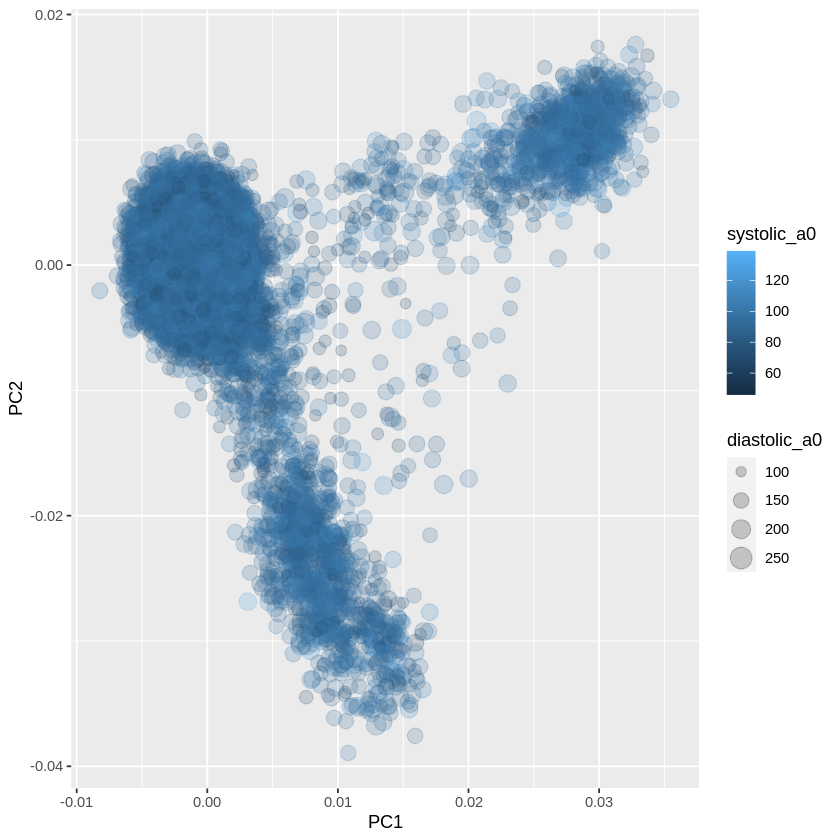

In [11]:
pca  %>%
    ggplot(aes(x=PC1, y=PC2, color=systolic_a0, size=diastolic_a0)) +
    geom_point(alpha=0.2)

Further, we plot population structure with individuals affected by hypertension superimposed on the plot as colour (representing summary diagnosis field) and shape (representing self-reported hypertension field).

From PCA plots we can see that the participant hypertension diagnosis does not depend on population structure.


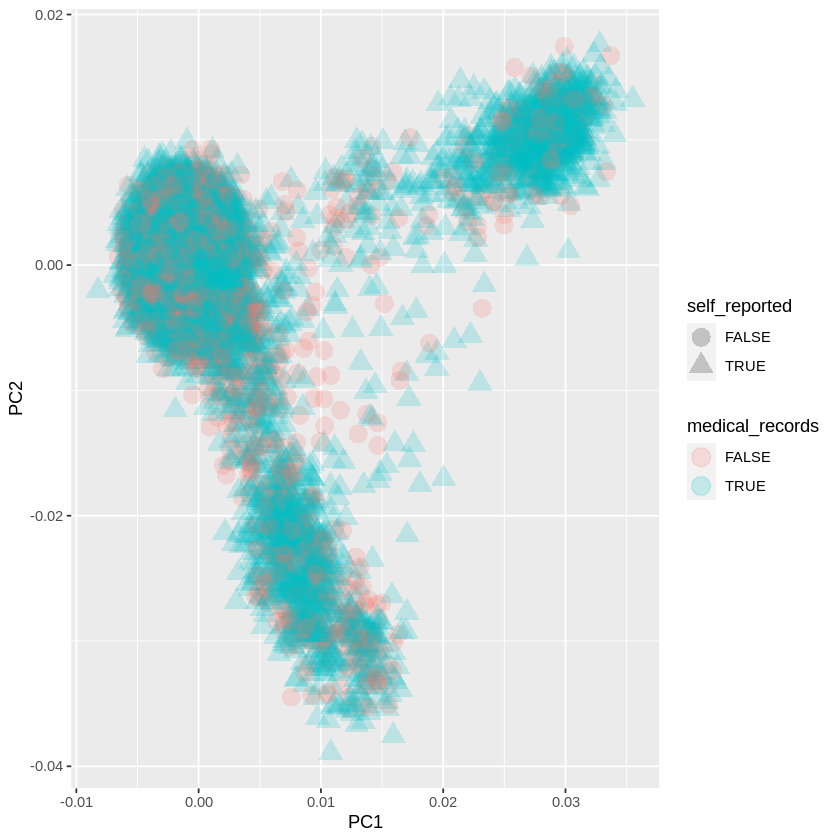

In [12]:
pca  %>%
    ggplot(aes(x=PC1, y=PC2, color=medical_records, shape=self_reported)) +
    geom_point(alpha=0.2, size=5)

We can also see how our population data and hypertension diagnosis relates to participant ethnicity. This way we assess that there is no significant bias for hypertension diagnosis in any ethnic group.

Here we download and read participant ethnicity information created in **Notebook 202**.

In [8]:
system('dx download -f pheno/ethnicity_processed.csv', intern=TRUE)
ethnicity <- read_csv('ethnicity_processed.csv')

Next, we will plot the PCA population structure with ethnicity (as colour) and blood pressure measurement (as point size) overlays.

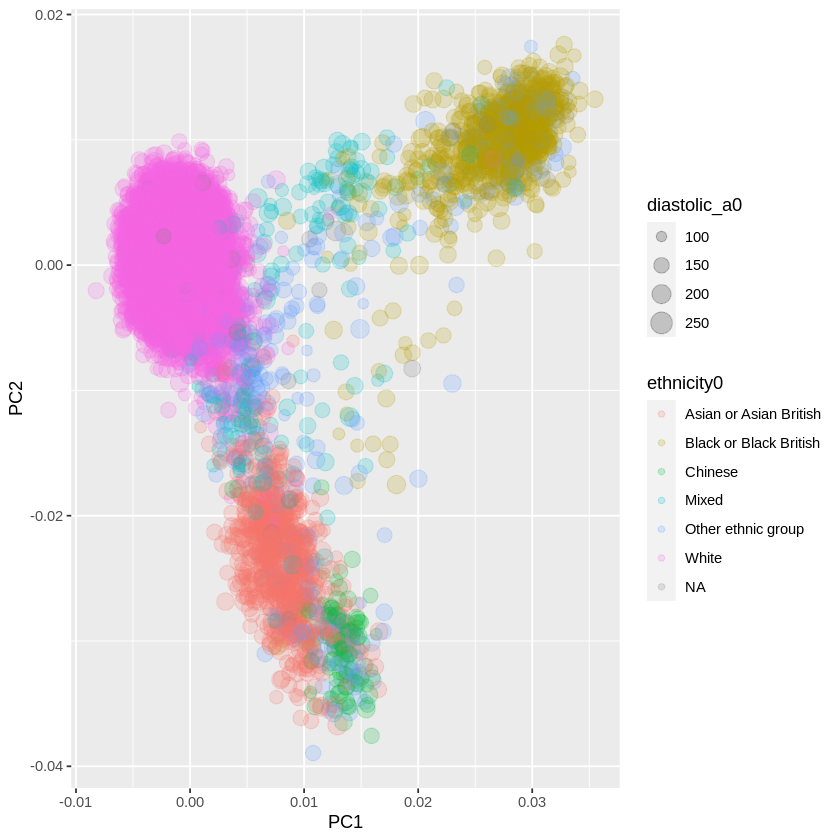

In [14]:
pca  %>% left_join(ethnicity, by='eid') %>%
    ggplot(aes(x=PC1, y=PC2, color=ethnicity0, size=diastolic_a0)) +
    geom_point(alpha=0.2)

## Running GWAS model

### Linear regression models

In this step, we are performing genome-wide association analyses using a linear regression implemented in the `bigsnpr` package. The regression model applies to continuous variables, like blood pressure measurements. 

In [15]:
lin_reg <- big_univLinReg(
  genotypes_smpl$genotypes, 
  y.train = pca$diastolic_a0,
  covar.train = obj.svd$u,
  ncores = NCORES)

We can preview linear regression model results:

In [ ]:
str(lin_reg)

### Logistic regression model

In this step, we are performing genome-wide association analyses using a logistic regression implemented in `bigsnpr` package. While linear regression is used for continuous values (e.g. height, blood pressure), logistic regression is useful for categorical variables (e.g, affected vs not affected, summary diagnosis).

In [17]:
log_reg <- big_univLogReg(
    X = genotypes_smpl$genotypes, 
    y01.train = as.numeric(pca$medical_records),
    covar.train = obj.svd$u, 
    ncores = NCORES
)

We can preview logistic regression model results:

In [ ]:
str(log_reg)

### Diagnostic plots

#### Histogram showing the p-value distribution:

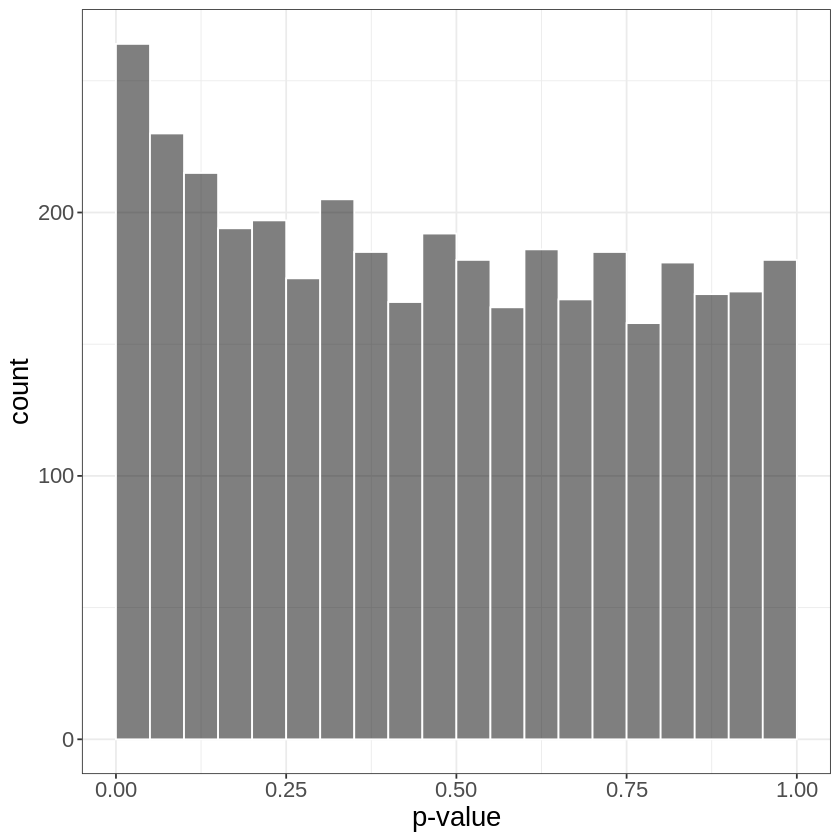

In [19]:
plot(log_reg)

#### Q-Q plot of the GWAS

We can diagnose the model performance with the quantile-quantile plot from p-values obtained by the GWAS model. We expect the observed and predicted values to be the same for most of the distribution (line up diagonally) and differ in the high statistical significance region (deviate from a diagonal line).

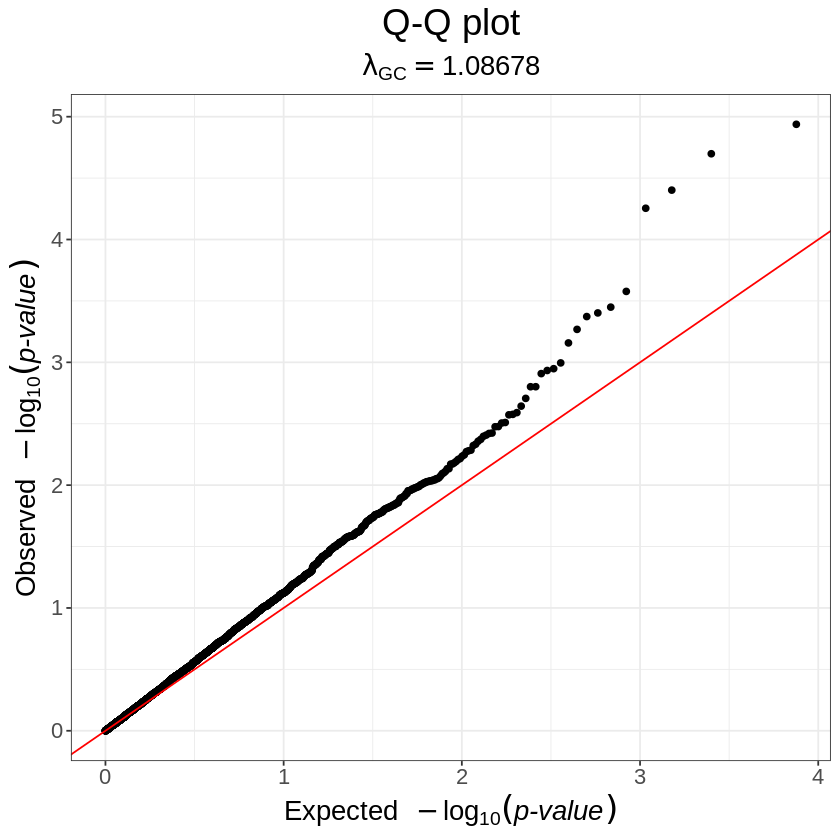

In [20]:
snp_qq(log_reg)

#### Manhattan plots

Manhattan plots are very useful as a way to illustrate the significant variants and variant clustering in the genome. The X-axis represents the genomic position, while Y-axis show a negative log scaled p-value. This scaling allows us to show statistical significance intuitively – the most significant variants are represented at the top of the plot. 

Manhattan plot for the logistic regression model:

> The x-axis show variant location in the genome and y-axis the statistical significance (reversed p-value in log space)

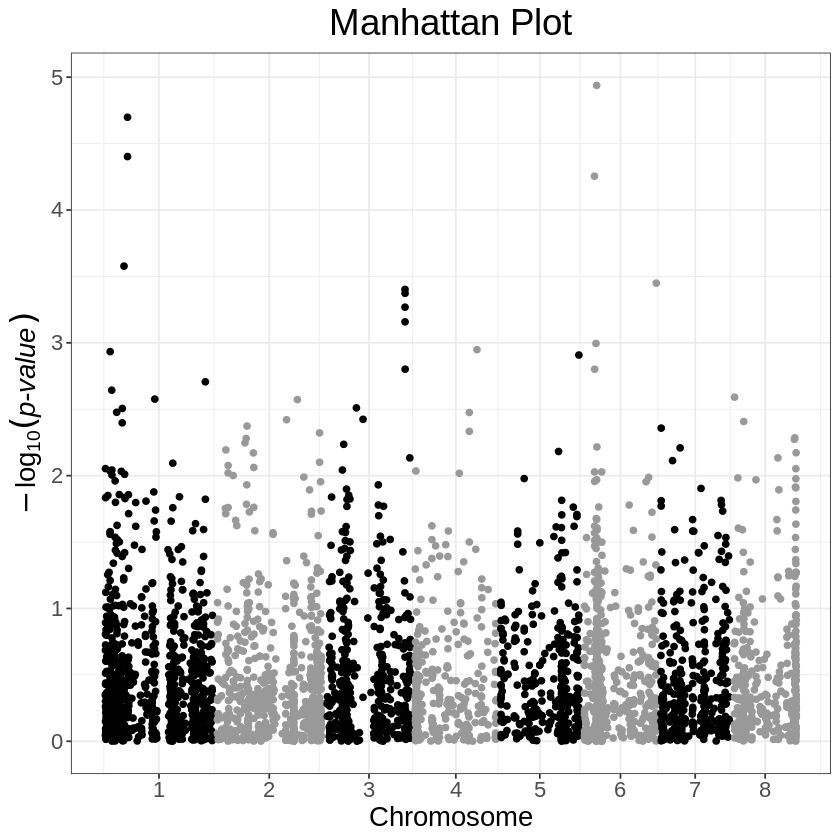

In [21]:
snp_manhattan(log_reg, infos.chr = as.integer(as.factor(CHR)), infos.pos = POS)

Manhattan plot for linear regression model: 

> The x-axis show variant location in the genome and y-axis the statistical significance (reversed p-value in log space)

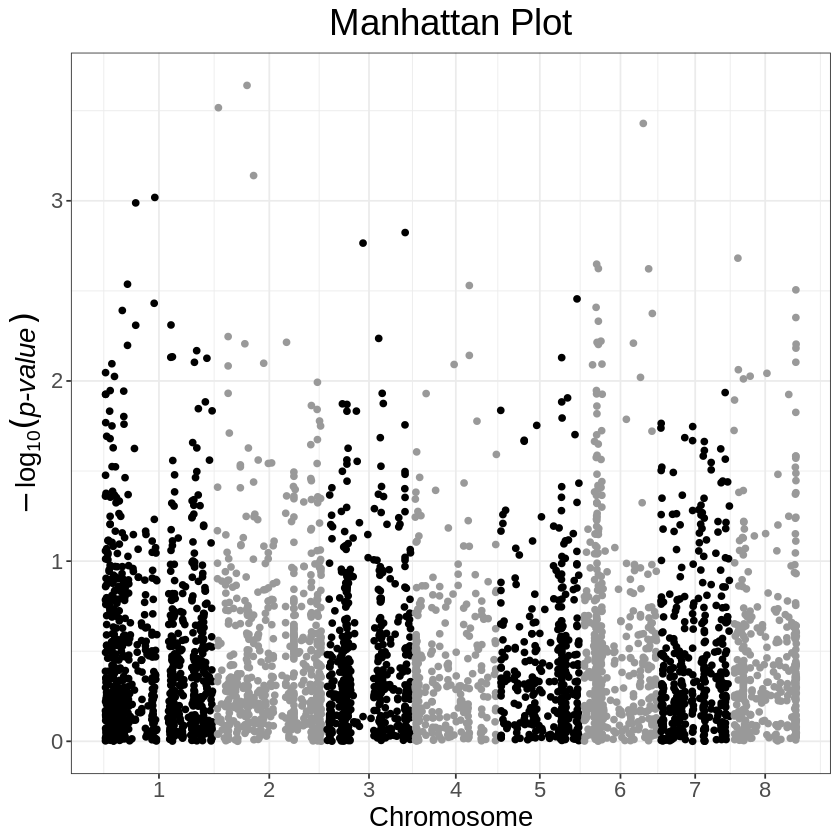

In [22]:
snp_manhattan(lin_reg, infos.chr = as.integer(as.factor(CHR)), infos.pos = POS)